In [2]:
%reload_ext autoreload
%autoreload 2

from sklearn.model_selection import KFold
import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from preprocessing_train_test import *
import matplotlib.pyplot as plt


from scipy.stats import skew 
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

pd.set_option('display.max_columns', 100)  # 设置显示100列
pd.set_option('display.max_rows', 100)   # 设置显示100行

/Users/hudongyue/opt/anaconda3/envs/envname/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [3]:
file_path_train = "../data/backup/merge_auxiliary_data_train.csv"
file_path_test = "../data/backup/merge_auxiliary_data_test.csv"

train_gdf = pd.read_csv(file_path_train)
test_gdf = pd.read_csv(file_path_test)

print("train dataset shape: ", train_gdf.shape)
print("test dataset shape: ",test_gdf.shape)

train dataset shape:  (431732, 55)
test dataset shape:  (107934, 54)


## XGBRegressor

In [46]:
max_depths = [6, 7, 8, 9]
min_child_weights = [1.2, 1.3, 1.4]
reg_alphas = [1.5, 1.6, 1.7] 
reg_lambdas = [1.5, 1.55, 1.6]

scores_xgb = {}
for max_depth in max_depths:
    for min_child_weight in min_child_weights:
        for reg_alpha in reg_alphas:
            for reg_lambda in reg_lambdas:
                print('start training with max_depth: {}, min_child_weight: {}, reg_alpha: {}, reg_lambda: {}'.format(max_depth, min_child_weight, reg_alpha, reg_lambda))
                mae_test, mae_valid, mse_test, mse_valid = [], [], [], []
                split = KFold(n_splits=5, shuffle=True).split(train_gdf)
                for idx, (train_idx, validate_idx) in enumerate(split):
                    print('fold {}'.format(idx + 1))
                    train_df, validate_df = preprocess_train_test(train_gdf.iloc[list(train_idx)], train_gdf.iloc[list(validate_idx)])

                    x_train, y_train = train_df.drop(columns=["resale_price"], errors='ignore'), train_df["resale_price"]
                    x_valid, y_valid = validate_df.drop(columns=["resale_price"], errors='ignore'), validate_df["resale_price"]

                    features = pd.concat([x_train, x_valid]).reset_index(drop=True)
                    # overfit = []
                    # for i in features.columns:
                    #     counts = features[i].value_counts()
                    #     zeros = counts.iloc[0]
                    #     if zeros / len(features) * 100 > 99.94:
                    #         overfit.append(i)

                    # overfit = list(overfit)
                    final_features = features.drop(columns=['primary_id', 'second_id', 'mall_id'], axis=1)
                    # final_features = features.drop(columns=overfit, axis=1)
                    # final_features = features.iloc[:, :60]

                    x_train = final_features.iloc[:len(x_train), :]
                    x_valid = final_features.iloc[len(x_train):, :]

                    regressor = xgb.XGBRegressor(n_estimators=1400, max_depth=max_depth, min_child_weight=min_child_weight, reg_alpha=reg_alpha, reg_lambda=reg_lambda, subsample=1, n_jobs=3).fit(x_train, y_train)
                    
                    y_train_predict = regressor.predict(x_train)
                    y_valid_predict = regressor.predict(x_valid)

                    mae_test.append(mean_absolute_error(y_train, y_train_predict))
                    mae_valid.append(mean_absolute_error(y_valid, y_valid_predict))
                    mse_test.append(mean_squared_error(y_train, y_train_predict))
                    mse_valid.append(mean_squared_error(y_valid, y_valid_predict))

                print(mae_test, mae_valid, mse_test, mse_valid)
                scores_xgb[(max_depth, min_child_weight, reg_alpha, reg_lambda)] = (mae_test, mae_valid, mse_test, mse_valid)

start training with max_depth: 6, min_child_weight: 1.3, reg_alpha: 1.6, reg_lambda: 1.55
fold 1
fold 2
fold 3
fold 4
fold 5
[9266.453587621168, 9287.203001335938, 9282.786987583408, 9308.06973242891, 9289.382392380516] [11721.26806127095, 11803.310206882186, 11792.703757158697, 11779.721233817287, 11766.766135597987] [157818613.32877317, 158714033.60133395, 158330645.71937108, 159237465.06544283, 158469388.71588218] [278139624.66029316, 279817605.14267087, 280596078.13053757, 281832190.6555247, 282603805.1240578]


In [47]:
min_mae_key, min_mae = None, 100000
min_mse_key, min_mse = None, 10000000000000
for key, (_, mae_valid, _, mse_valid) in scores_xgb.items():
    if np.mean(mae_valid) < min_mae:
        min_mae_key = key
        min_mae = np.mean(mae_valid)
    if np.mean(mse_valid) < min_mse:
        min_mse_key = key
        min_mse = np.mean(mse_valid)
print(min_mae_key, min_mae)
print(min_mse_key, min_mse)

(6, 1.3, 1.6, 1.55) 11772.753878945423
(6, 1.3, 1.6, 1.55) 280597860.7426168


9639.726686491827
171895229.56513634
[9.75090172e-03 6.71585323e-04 3.06046102e-04 3.54738149e-04
 2.24722666e-04 2.82812805e-04 1.08468893e-03 0.00000000e+00
 4.24408208e-04 1.77140301e-03 5.10657497e-04 4.83613665e-04
 4.50426131e-04 3.02103814e-04 4.42658900e-04 2.54869403e-04
 1.04971668e-02 4.37674066e-03 1.34551883e-04 2.13566513e-04
 5.56109124e-04 5.43148315e-04 4.36262402e-04 1.13031972e-04
 1.35968818e-04 3.30348877e-04 1.21017074e-04 3.94232746e-04
 5.24134724e-04 2.95831094e-04 5.31630823e-04 2.35615741e-03
 9.05857980e-03 9.72402049e-04 0.00000000e+00 1.14706147e-03
 1.09914236e-03 2.39691674e-03 5.79060335e-03 8.14213068e-04
 3.95066345e-05 5.69160700e-01 3.62536113e-04 0.00000000e+00
 8.58929823e-04 0.00000000e+00 0.00000000e+00 4.60838492e-05
 1.87924225e-02 4.81351570e-04 6.31073548e-04 7.65826041e-03
 3.23826470e-03 2.46239454e-02 7.62404583e-04 3.69969057e-03
 2.99839824e-01 0.00000000e+00 1.15057605e-03 8.49998090e-03]


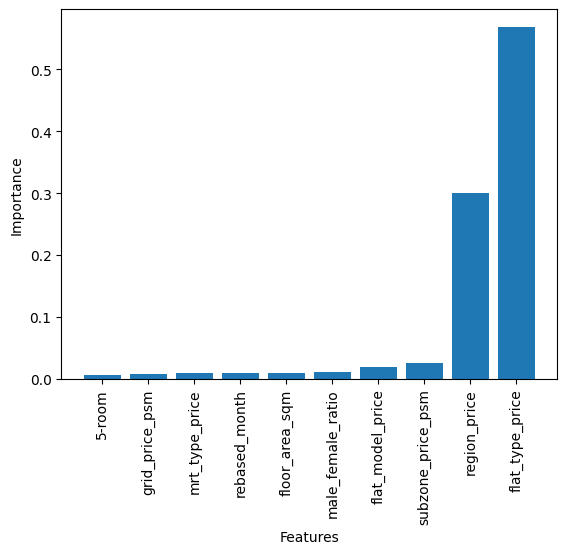

In [4]:
'''Run best random forest hyperparam on full dataset'''
test_gdf.drop(columns=["opening_year"], inplace=True, errors='ignore')
train_df, test_df = preprocess_train_test(train_gdf, test_gdf)

x_train, y_train = train_df.drop(columns=["resale_price"], errors='ignore'), train_df["resale_price"]
features = pd.concat([x_train, test_df])

# features_tmp = features
features_tmp = features.iloc[:, :60]
# features_tmp = features.drop(columns=['distance_to_mrt_bins_price', 'mrt_lrt_links', 'population_bins_price', 'adult_children_ratio_bins_price', 'mrt_interchange_flag', 'mrt_interchange_count', 'mrt_type_price'], errors='ignore')
# features_tmp = features.drop(columns=['distance_to_mrt_bins_price', 'mrt_lrt_links', 'population_bins_price'], errors='ignore')

x_train = features_tmp.iloc[:len(train_df), :]
x_test = features_tmp.iloc[len(train_df):, :]


regressor = xgb.XGBRegressor(n_estimators=1300, max_depth=6, min_child_weight=1.3, reg_alpha=1.6, reg_lambda=1.5, n_jobs=3).fit(x_train, y_train)
# regressor = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
#                              learning_rate=0.05, max_depth=6, 
#                              min_child_weight=1.5, n_estimators=500,
#                              reg_alpha=1, reg_lambda=0.8571,
#                              subsample=0.5213, nthread = -1).fit(x_train, y_train)

y_train_predict = regressor.predict(x_train)
# y_valid_predict = regressor.predict(x_valid)

print(mean_absolute_error(y_train, y_train_predict))
# mae_valid.append(mean_absolute_error(y_valid, y_valid_predict))
print(mean_squared_error(y_train, y_train_predict))
# mse_valid.append(mean_squared_error(y_valid, y_valid_predict))

# compute feature importances using the Gini importance method
importances = regressor.feature_importances_

# get the indices of the top 10 most important features
idx = importances.argsort()[-10:]
print(importances)

# plot the top 10 features
plt.bar(range(len(idx)), importances[idx])
plt.xticks(range(len(idx)), features_tmp.columns[idx], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

In [24]:
y_test_predict = regressor.predict(x_test)


In [26]:
submission = pd.DataFrame({
        "Predicted": y_test_predict
    })

submission.to_csv("PredictedPrice.csv", index=True, index_label="Id")


## Lightgbm

In [ ]:
num_leaves = [4, 6]
max_bins = [100, 200]
bagging_fractions = [0.7, 0.8] 
bagging_freqs = [3, 10]

# num_leaves = [4]
# max_bins = [100, 400]
# bagging_fractions = [0.75] 
# bagging_freqs = [3]

scores_lightgbm = {}
for num_leave in num_leaves:
    for max_bin in max_bins:
        for bagging_fraction in bagging_fractions:
            for bagging_freq in bagging_freqs:
                print('start training with num_leave: {}, max_bin: {}, bagging_fraction: {}, bagging_freq: {}'.format(num_leave, max_bin, max_bin, bagging_fraction))
                mae_test, mae_valid, mse_test, mse_valid = [], [], [], []
                split = KFold(n_splits=5, shuffle=True).split(train_gdf)
                for idx, (train_idx, validate_idx) in enumerate(split):
                    print('fold {}'.format(idx + 1))
                    train_df, validate_df = preprocess_train_test(train_gdf.iloc[list(train_idx)], train_gdf.iloc[list(validate_idx)])

                    x_train, y_train = train_df.drop(columns=["resale_price"], errors='ignore'), train_df["resale_price"]
                    x_valid, y_valid = validate_df.drop(columns=["resale_price"], errors='ignore'), validate_df["resale_price"]

                    features = pd.concat([x_train, x_valid]).reset_index(drop=True)
                    overfit = []
                    for i in features.columns:
                        counts = features[i].value_counts()
                        zeros = counts.iloc[0]
                        if zeros / len(features) * 100 > 99.94:
                            overfit.append(i)

                    overfit = list(overfit)
                    final_features = features.drop(overfit, axis=1)

                    x_train = final_features.iloc[:len(x_train), :]
                    x_valid = final_features.iloc[len(x_train):, :]

                    regressor = LGBMRegressor(objective='regression', 
                                                n_estimators=300,
                                                num_leaves=num_leave,
                                                max_bin=max_bin, 
                                                learning_rate=0.01, 
                                                bagging_fraction=bagging_fraction,
                                                bagging_freq=bagging_freq, 
                                                bagging_seed=7,
                                                feature_fraction=0.2,
                                                feature_fraction_seed=7).fit(x_train, y_train)                    
                    y_train_predict = regressor.predict(x_train)
                    y_valid_predict = regressor.predict(x_valid)

                    mae_test.append(mean_absolute_error(y_train, y_train_predict))
                    mae_valid.append(mean_absolute_error(y_valid, y_valid_predict))
                    mse_test.append(mean_squared_error(y_train, y_train_predict))
                    mse_valid.append(mean_squared_error(y_valid, y_valid_predict))

                print(mae_test, mae_valid, mse_test, mse_valid)
                scores_lightgbm[(max_depth, min_child_weight, reg_alpha, reg_lambda)] = (mae_test, mae_valid, mse_test, mse_valid)

In [15]:
'''Run best random forest hyperparam on full dataset'''
test_gdf.drop(columns=["opening_year"], inplace=True, errors='ignore')
train_df, test_df = preprocess_train_test(train_gdf, test_gdf)

x_train, y_train = train_df.drop(columns=["resale_price"], errors='ignore'), train_df["resale_price"]

# x_valid, y_valid = validate_df.drop(columns=drop_columns, errors='ignore'), validate_df["resale_price"]

regressor = LGBMRegressor(objective='regression', 
                            n_estimators=500,
                            num_leaves=num_leave,
                            max_bin=max_bin, 
                            learning_rate=0.01, 
                            bagging_fraction=bagging_fraction,
                            bagging_freq=bagging_freq, 
                            bagging_seed=7,
                            feature_fraction=0.2,
                            feature_fraction_seed=7).fit(x_train, y_train)
y_train_predict = regressor.predict(x_train)
# y_valid_predict = regressor.predict(x_valid)

print(mean_absolute_error(y_train, y_train_predict))
# mae_valid.append(mean_absolute_error(y_valid, y_valid_predict))
print(mean_squared_error(y_train, y_train_predict))
# mse_valid.append(mean_squared_error(y_valid, y_valid_predict))

In [16]:
min_mae_key, min_mae = None, 100000
min_mse_key, min_mse = None, 10000000000000
for key, (_, mae_valid, _, mse_valid) in scores_lightgbm.items():
    if np.mean(mae_valid) < min_mae:
        min_mae_key = key
        min_mae = np.mean(mae_valid)
    if np.mean(mse_valid) < min_mse:
        min_mse_key = key
        min_mse = np.mean(mse_valid)
print(min_mae_key, min_mae)
print(min_mse_key, min_mse)

(6, 2, 1, 1) 45387.7810192872
(6, 2, 1, 1) 3554484391.690834
